### Initial exploration of data features
In this notebook we will analyse some of the initial data, by finding out what features are available, what granularity the data comes in, as well as seeing if there is any obvious noise we need to take into account.

In [18]:
## Loading in the data from data/experiments/experiment_1, which contains button_presses.csv for the labels, and other csv files for the features. In experiments_1/meta we have the system time and the device info
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def load_data(path):
    # Load the starting time
    time_df = pd.read_csv(path + 'meta/time.csv')
    start_time = time_df.loc[time_df['event'] == 'START', 'system time'].iloc[0]

    data_frames = []
    for filename in os.listdir(path):
        if filename.endswith(".csv"):
            df = pd.read_csv(path + filename)
            # Check if 'Time (s)' column exists
            if 'Time (s)' in df.columns:
                # Convert 'Time (s)' column to datetime index for each dataframe
                df.index = pd.to_datetime(df['Time (s)'], unit='s', origin=pd.Timestamp(start_time, unit='s'))
                data_frames.append(df)
            else:
                print(f"'Time (s)' column not found in file: {filename}")
                print(f"Columns found: {df.columns}")
    
    # Concatenate dataframes
    data = pd.concat(data_frames)
    
    # resample to 10 Hz
    data_resampled = data.resample('100ms').mean()
    
    return data_resampled

data = load_data("data/experiments/experiment_1/")


'Time (s)' column not found in file: button_presses.csv
Columns found: Index(['1686395517', 'straight-btn'], dtype='object')


c:\Users\lverm\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\lverm\AppData\Local\Temp\ipykernel_120352\1028154604.py:48: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(bins=30, ax=ax)


Cannot decompose Time (s)
Cannot decompose X (m/s^2)
Cannot decompose Y (m/s^2)
Cannot decompose Z (m/s^2)
Cannot decompose X (hPa)
Cannot decompose X (rad/s)
Cannot decompose Y (rad/s)
Cannot decompose Z (rad/s)
Cannot decompose Latitude (°)
Cannot decompose Longitude (°)
Cannot decompose Height (m)
Cannot decompose Velocity (m/s)
Cannot decompose Direction (°)
Cannot decompose Horizontal Accuracy (m)
Cannot decompose Vertical Accuracy (°)
Cannot decompose X (µT)
Cannot decompose Y (µT)
Cannot decompose Z (µT)
Cannot decompose Distance (cm)


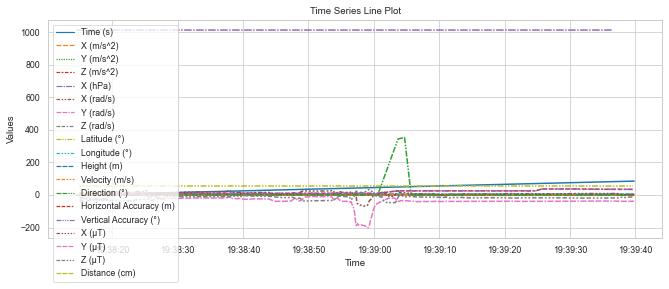

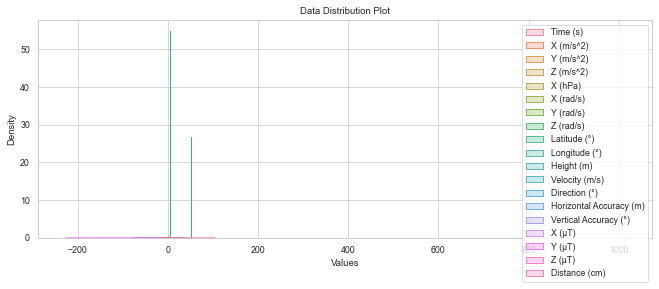

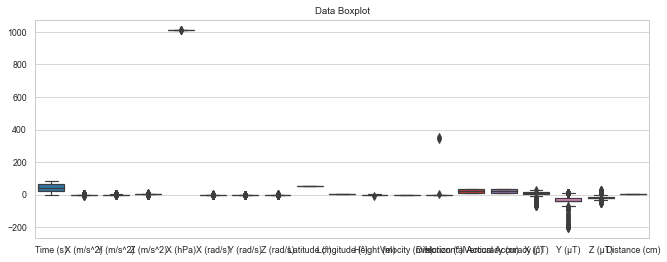

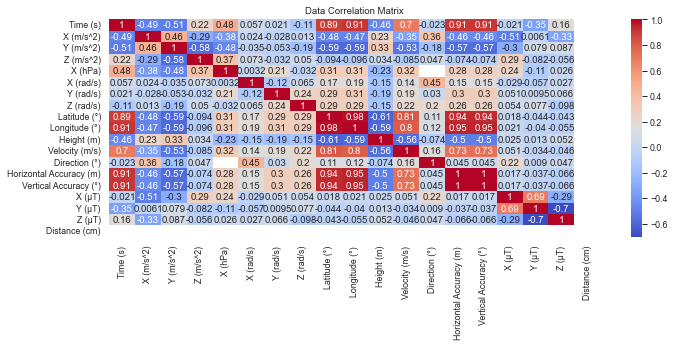

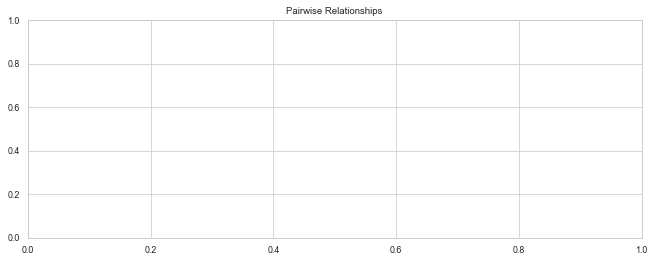

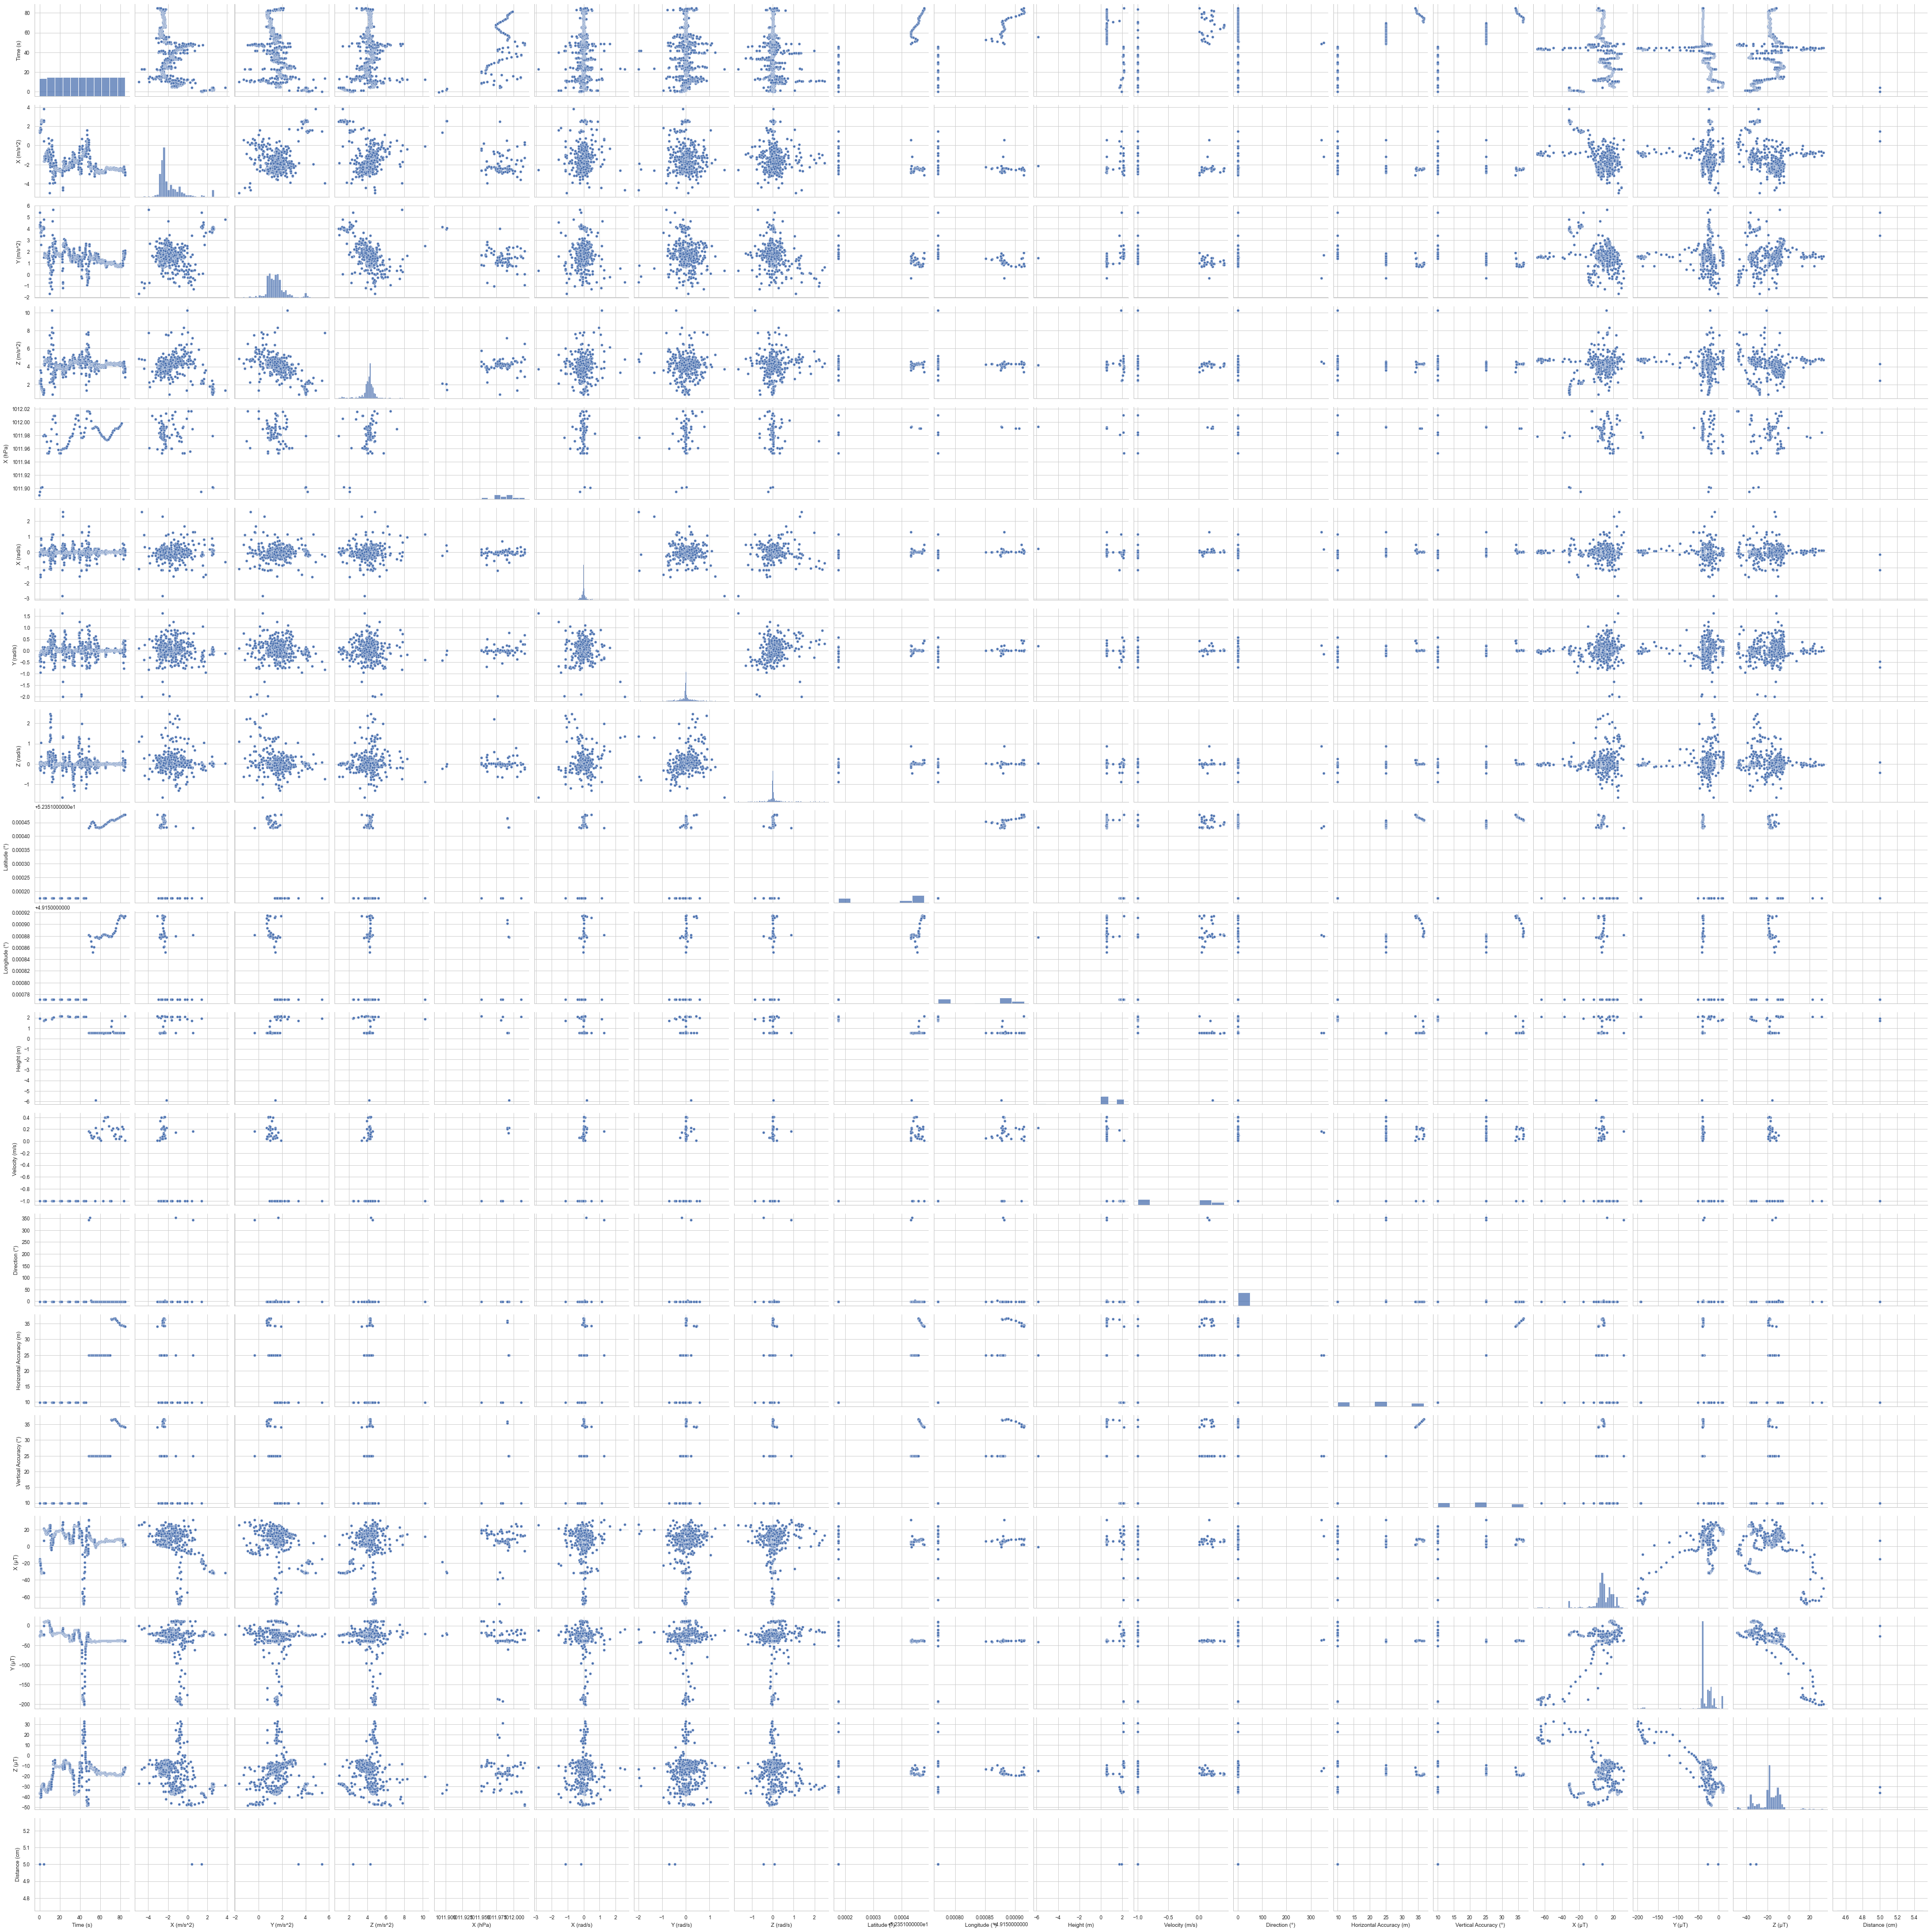

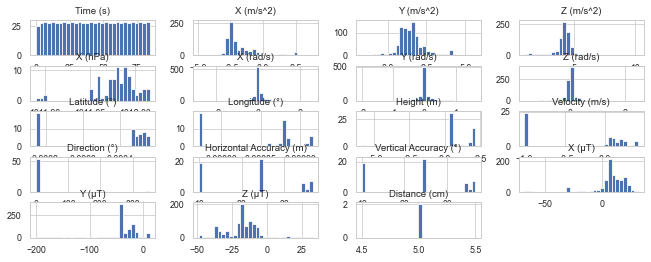

In [22]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_data(data, output_path):
    # Set Seaborn style and context
    sns.set_style("whitegrid")
    sns.set_context("paper")

    # Line plot
    fig, ax = plt.subplots()
    sns.lineplot(data=data, palette="tab10", linewidth=1.5, ax=ax)
    ax.set_title('Time Series Line Plot')
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    fig.savefig(output_path + 'line_plot.pdf')

    # Distribution of the data
    fig, ax = plt.subplots()
    sns.kdeplot(data=data, ax=ax, fill=True)
    ax.set_title('Data Distribution Plot')
    ax.set_xlabel('Values')
    fig.savefig(output_path + 'distribution_plot.pdf')

    # Boxplots of the data
    fig, ax = plt.subplots()
    sns.boxplot(data=data, palette="tab10", ax=ax)
    ax.set_title('Data Boxplot')
    fig.savefig(output_path + 'boxplot.pdf')

    # Correlation matrix of the data
    fig, ax = plt.subplots()
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', ax=ax)
    ax.set_title('Data Correlation Matrix')
    fig.savefig(output_path + 'correlation_matrix.pdf')

    # Pairwise relationships
    fig, ax = plt.subplots()
    sns.pairplot(data)
    ax.set_title('Pairwise Relationships')
    fig.savefig(output_path + 'pairwise_relationships.pdf')

    # Histogram
    fig, ax = plt.subplots()
    data.hist(bins=30, ax=ax)
    ax.set_title('Data Histogram')
    fig.savefig(output_path + 'histogram.pdf')

    # Time series decomposition
    for col in data.columns:
        try:
            result = seasonal_decompose(data[col], model='additive', period=1)
            fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,8))
            result.observed.plot(ax=ax1)
            ax1.set_ylabel('Observed')
            result.trend.plot(ax=ax2)
            ax2.set_ylabel('Trend')
            result.seasonal.plot(ax=ax3)
            ax3.set_ylabel('Seasonal')
            result.resid.plot(ax=ax4)
            ax4.set_ylabel('Residual')
            fig.savefig(output_path + f'{col}_decomposition.pdf')
        except:
            print(f"Cannot decompose {col}")

output_path = "data/experiments/experiment_1/figures/"
plot_data(data, output_path)
